In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
import matplotlib as mpl
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [18, 10]
plt.style.use('ggplot')
mpl.rcParams['axes.color_cycle'] = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854'] #from http://colorbrewer2.org\

### Loading data

In [95]:
X_data = pd.read_csv('https://raw.githubusercontent.com/vlosing/driftDatasets/master/artificial/hyperplane/rotatingHyperplane.data',
                sep=' ',
                header=None)
y_data = pd.read_csv('https://raw.githubusercontent.com/vlosing/driftDatasets/master/artificial/hyperplane/rotatingHyperplane.labels',
                header=None)

### Getting first and last 10% of data

In [96]:
x_start = X_data[:20000]
y_start = y_data[:20000]
x_end = X_data[-20000:]
y_end = y_data[-20000:]

### Splitting data to train and test

In [97]:
x_train_start, x_test_start, y_train_start, y_test_start = train_test_split(x_start,
                                                                            y_start,
                                                                            random_state=123)
x_train_end, x_test_end, y_train_end, y_test_end = train_test_split(x_end,
                                                                    y_end,
                                                                    random_state=123)

### Building two linear models

In [98]:
log_start = LogisticRegression()
log_start.fit(x_train_start, y_train_start)
log_end = LogisticRegression()
log_end.fit(x_train_end, y_train_end)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Plotting variable drift

In [205]:
def plot_variable_drift(x_start, x_end, bins = 25, positive=True):
    if positive:
        bins = np.linspace(0, 1, bins + 1)
    else:
        bins = np.linspace(-1, 1, bins + 1)
    for i in range(len(x_start.columns)):
        plt.subplot(3, 4, i+1)
        joined_data = pd.concat([x_start[i], x_end[i]])
        start_hist, _, _ = plt.hist(x_start[i], bins=bins, density=True, alpha=0.6, label="First part")
        end_hist, _, _ = plt.hist(x_end[i], bins=bins, alpha=0.6, density=True, label="Last part")
        
        intersect = np.minimum(start_hist, end_hist).dot(np.diff(bins))
        plt.title(f'Var {str(i)} -> overlap {intersect.round(4)}')
        plt.legend(loc=4)
    plt.tight_layout()
    plt.show()

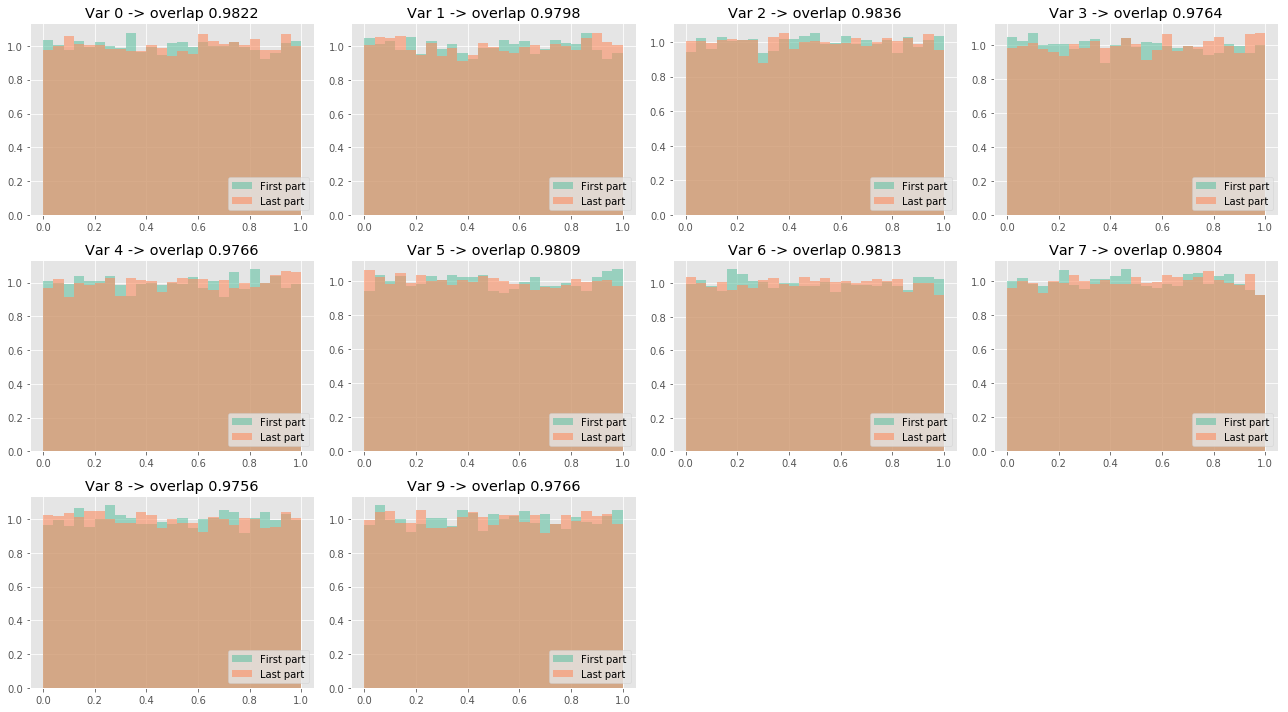

In [206]:
plot_variable_drift(x_start, x_end)

##### Pomiędzy danymi z początku i końca zbioru nie ma znaczących różnic, co jest widoczne w dużej części wspólnej obu zbiorów dla wszystkich zmiennych. 

### Plotting resuduals drift

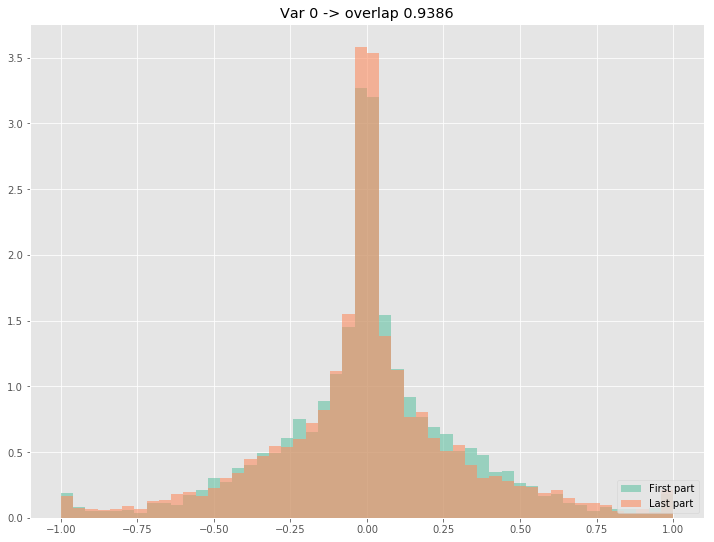

In [151]:
plt.rcParams['figure.figsize'] = [70, 20]
plot_variable_drift(pd.DataFrame(np.array(y_test_start.values.reshape(-1)) - log_start.predict_proba(x_test_start)[:,1]),
                pd.DataFrame(np.array(y_test_end.values.reshape(-1)) - log_end.predict_proba(x_test_end)[:,1]),
                positive=False,
                   bins=50)

#### Reszty z obu modeli również nie różnią się znacząco, rozkład ma 93% wspólnej powierzchni.

### Area between ALE plots

In [152]:
def ale_func(X_data, model, chosen_feature, bins):
    data_inner = X_data.copy()
    data_inner['range_left'] = pd.cut(X_data[chosen_feature], bins).apply(lambda x: x.left).astype(float)
    data_inner['range_right'] = pd.cut(X_data[chosen_feature], bins).apply(lambda x: x.right).astype(float)
    
    lower_limit = data_inner.copy()
    lower_limit[chosen_feature] = lower_limit['range_left']
    higher_limit = data_inner.copy()
    higher_limit[chosen_feature] = higher_limit['range_right']
    
    lower_limit['target'] = model.predict(lower_limit.drop(['range_left', 'range_right'], axis=1))
    higher_limit['target'] = model.predict(higher_limit.drop(['range_left', 'range_right'], axis=1))
    
    higher_limit['diff'] = higher_limit['target'] - lower_limit['target']
    higher_limit['x_diff'] = (higher_limit['range_right'] + lower_limit['range_left'])/2
    values = higher_limit.groupby(['range_right']).mean()
    return (values['x_diff'].ravel(), np.cumsum(values['diff']).ravel())


In [207]:
def plot_ale_diff(x_test_start, x_test_end, log_start, log_end):
    for i in range(len(x_start.columns)):
        plt.subplot(3, 4, i+1)
        x1, y1  = ale_func(x_test_start, log_start, i, bins=25)
        x2, y2  = ale_func(x_test_end, log_end, i, bins=25)
        area = abs(y1 - y2)[1:].dot(np.diff(x1))
        plt.plot(x1, y1, label="First part")
        plt.plot(x2, y2, label='Last part')
        plt.fill_between(x1, y1, y2, color='#B1A884', alpha=0.3)
        plt.ylim([-0.8,0.8])
        plt.title(f'Var {str(i)} -> area {area.round(4)}')
        plt.tight_layout()
        plt.legend()
    plt.show()    

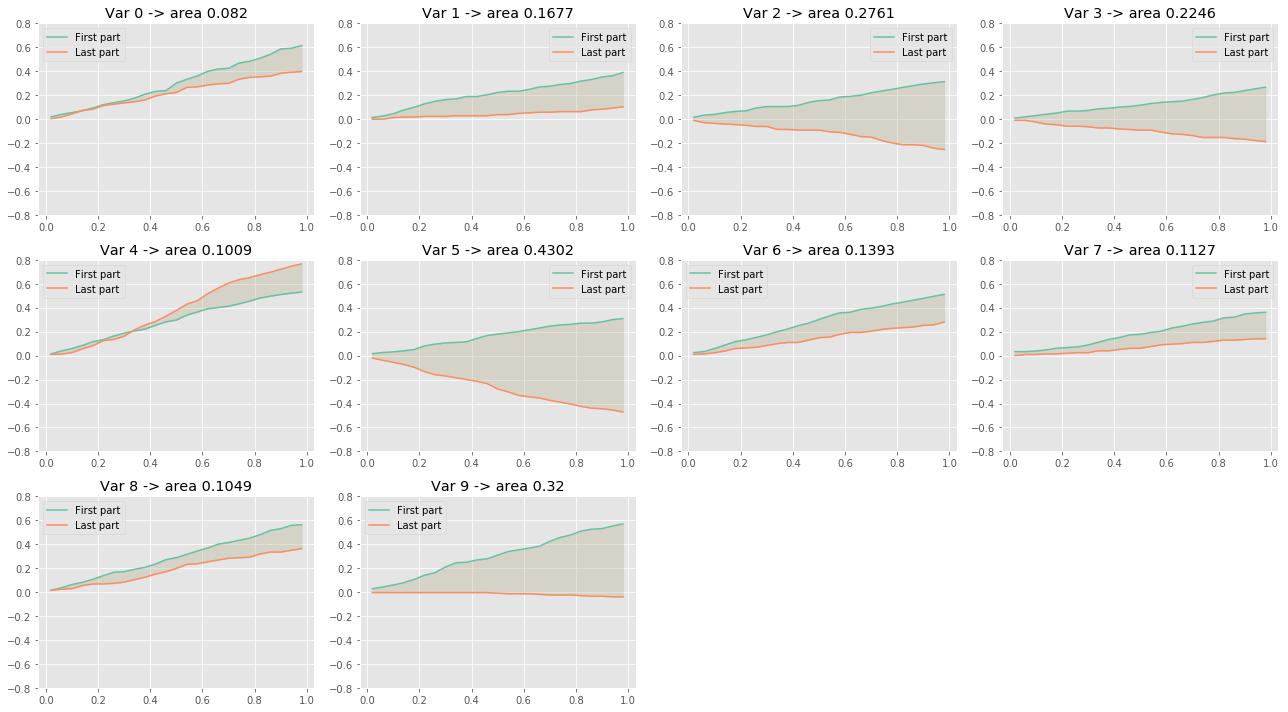

In [208]:
plt.rcParams['figure.figsize'] = [18, 10]
plot_ale_diff(x_test_start, x_test_end, log_start, log_end)

#### Największe różnice w wykresach ALE są dla zmiennych numer 2, 5 i 9. Pozostałe wykazują dość podobne charakterystyki. 